This notebook should walk through how we'll be reading in the data and give the basics on how to get started on making plots.  The matplotlib documentation (both official and on stackexchange) is usually pretty good, but can be tricky getting started.

Note that with a jupyter notebook you can designate cells as either code or markdown text, like this one is, for more comprehensive comments.


In [2]:
import numpy as np
import pandas as pd
import scipy as sc
import uproot as up
import matplotlib.pyplot as plt
#packages we'll need

%matplotlib inline 
#this is a ``magic command'' specific to display plots in-line in a jupyter notebook
#normally you would plot by calling a plt.show()


from matplotlib.colors import LogNorm
#need this for the colourbar of the 2D histogram

In [3]:

# merge get dataframes from .root files and 
def set_dataframe(num_towers, path):
    frames = []

    for t in range(1, num_towers + 1):
        new_path = path + str(t) + '.root'

        #load tower
        event = up.open(new_path)['tree']

        #recast the data as a pandas dataframe and append to frames
        frames.append(event.pandas.df())
    
    return pd.concat(frames)
    
    
    
my_path = '/Users/julianyocum/UROP/data/ds3564/ds3564Tower'

alldata = set_dataframe(19, my_path)

In [4]:
alldata

,Run,Channel,Time,NumPulses,OFdelay,MaxPosInWindow,SelectedEnergy,Baseline,MaxToBaseline,StabAmp
entry,,,,,,,,,,
0,350259,4,201.712,1,3.175603,3162,5.350868e+03,-2228.379725,2209.313868,6.922486e+03
1,350259,32,334.408,1,3.173095,3164,5.333960e+03,-4604.478149,3705.018311,7.599031e+03
2,350259,23,1922.776,1,3.209816,3208,4.736281e+03,-4649.411229,3223.717717,6.487084e+03
3,350259,6,3444.392,1,3.175244,3161,5.341670e+03,-4218.544189,3944.732849,7.330490e+03
4,350259,29,5731.368,1,3.168502,3158,5.415189e+03,-4729.856969,2827.517034,7.222236e+03
...,...,...,...,...,...,...,...,...,...,...
629575,350292,975,56754.517,0,9999.999000,3324,9.999999e+06,-5140.619446,134.950806,9.999999e+06
629576,350292,937,56872.128,1,3.177405,3176,5.286591e+03,-2585.631765,3640.902913,6.996134e+03
629577,350292,975,57397.425,0,9999.999000,7712,9.999999e+06,-5143.951182,118.415599,9.999999e+06


This displays the dataframe with all of our variables and events.

In [5]:
#to access a dataframe given by just one set of variables:
alldata['Run']
max(alldata['SelectedEnergy'])
max(alldata['Channel'])
max(alldata['Time'])

89308.504

In [6]:
#or more useful, to just access the array corresponding to one set of values:
alldata['Run'].values

array([350259, 350259, 350259, ..., 350292, 350292, 350292], dtype=uint32)

In [137]:
# returns array of event frequencies where channel - 1 is the index
def get_numchannelevents():
    # get num events per channel
    events = []
    for c in range(1,max(alldata['Channel']) + 1):
        events.append(len(alldata[alldata['Channel'] == c]))
    return events

events_per_channel = get_numchannelevents()

#print(events_per_channel)
#print(sum(events_per_channel)/ len(events_per_channel))

In [8]:
# find dead channels
def get_deadchannels(channel_events):
    ch = []
    for c in range(1,max(alldata['Channel']) + 1):     
        if channel_events[c - 1] == 0:
            ch.append(c)
    
    #for c in range()
    return ch

dead_channels = get_deadchannels(events_per_channel)

print("Dead channels are: " + str(dead_channels))

#alldata[alldata['Channel'] == 988]


Dead channels are: [117, 169, 792, 923]


In [9]:
from scipy import stats

#detect outliers using above threshold z-score
def get_noisychannels(channel_events):
    
    #detect outliers using z-score
    #threshold = 3.5
    #z_dist = np.abs(stats.zscore(channel_events))
    #return np.where(z_dist > threshold)
    
    #detect outliers using IQR
    threshold = 5
    Q1, Q3 = np.percentile(channel_events, 25), np.percentile(channel_events, 75)
    IQR = Q3 - Q1
    
    upper_bound = Q3 + IQR * threshold
    
    #print(channel_events[channel_events > upper_bound])
    
    return [c for c in range(1,max(alldata['Channel']) + 1) if channel_events[c - 1] > upper_bound]
    
    #return np.where(channel_events > upper_bound) 
    


    
noisy_channels = get_noisychannels(events_per_channel)

print("# of noisy channels: " + str(len(noisy_channels)) + "\n")

print("Noisy channels are: " + str(noisy_channels) + "\n")

print("Num of events per channel are: " + str([events_per_channel[i - 1] for i in noisy_channels]))


# of noisy channels: 17

Noisy channels are: [87, 361, 363, 364, 557, 558, 559, 570, 611, 713, 714, 715, 936, 973, 974, 975, 988]

Num of events per channel are: [70344, 333, 520, 539, 343, 415, 692, 317, 413, 620, 581, 3154, 483, 881, 926, 622849, 1405]


In [33]:
# get Dataframe which doesn't include noisy channels
not_noisydata = alldata[np.isin(alldata['Channel'],noisy_channels, invert=True)]

# get events above certain baseline + maxtobaseline from not_noisydata
louddata = not_noisydata[(not_noisydata['Baseline'] + not_noisydata['MaxToBaseline']) > 9000]

louddata

,Run,Channel,Time,NumPulses,OFdelay,MaxPosInWindow,SelectedEnergy,Baseline,MaxToBaseline,StabAmp
entry,,,,,,,,,,
6,350259,27,7191.136,1,3.175879,3637,23567.885857,-4515.251541,14154.884720,29155.087318
7,350259,28,7191.152,1,3.200379,3687,25765.831235,-5549.806880,15168.531703,29658.848249
98,350260,2,19239.648,1,3.165242,3517,31308.324329,-1669.523214,11263.895009,39683.776708
99,350260,1,19239.656,1,3.164472,3604,26767.777221,-2197.285110,11831.150467,31858.203222
100,350260,17,19239.664,1,3.359793,3754,31408.606063,-3511.258682,13117.887100,153361.492091
...,...,...,...,...,...,...,...,...,...,...
625959,350290,946,6267.936,1,3.146274,3127,33340.302933,-3856.221700,13447.789693,39082.955824
625964,350290,947,6267.984,1,3.242658,3206,26844.811556,-3487.122375,13077.729065,33053.434909
629270,350292,986,23742.688,1,3.145783,3462,36193.349092,-3413.161270,13032.366745,45656.897875


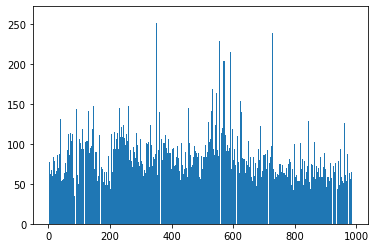

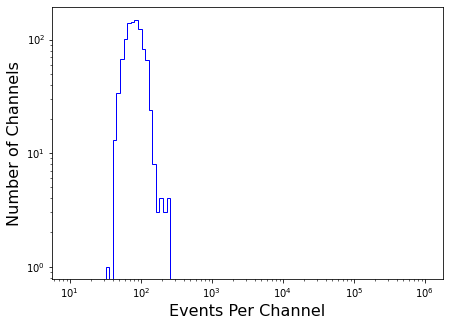

In [133]:
#CAN COMPARE WITH alldata VS not_noisydata

array=plt.hist(not_noisydata['Channel'].values, np.linspace(0,989,990) )#np.linspace function is hlepful for generating bins
distri=np.copy(array[0]) #make a copy so if I write over array I don't have probelms
plt.figure(figsize=(7,5)) # lets you make a custom size for your plot
plt.hist(distri, np.logspace(1,6,100),color='b', histtype='step' )
plt.xlabel('Events Per Channel',fontsize=16)
plt.ylabel('Number of Channels',fontsize=16)
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")

In [76]:

def get_clusterdata(df, e_thresh, t_thresh):
    sorted_df = df.sort_values(by=['Time'])
    sorted_df = sorted_df.reset_index(drop=True)
    
    new_df = sorted_df.copy()
        
    clusters = []
        
    #get events that are clustered
    row = 0
    events = 1
    cluster = [row]
    while (row < len(df)):
        
        #make sure there is a next event. if at end of dataframe, set times to fail next test
        if(row < len(df) - 1):
            successive_time = sorted_df.iloc[row + 1]['Time'] + sorted_df.iloc[row + 1]['MaxPosInWindow']/1000.0
            event_time = sorted_df.iloc[row]['Time'] + sorted_df.iloc[row]['MaxPosInWindow']/1000.0
        else:
            event_time = 0
            successive_time = time_threshold
            
            
        if abs(successive_time - event_time) < t_thresh:
            events += 1
            cluster.append(row + 1)
        else:
            #print(events)
            if events < e_thresh:
                for i in cluster:
                    new_df = new_df.drop(sorted_df.index[i])
            else:
                clusters.append(cluster)
            
            events = 1
            cluster = [row + 1]
            
        row += 1
        
    return (new_df, clusters)


In [138]:
event_threshold = 5
time_threshold = .1
    
timeclusterdata, timeclusters = get_clusterdata(louddata, event_threshold, time_threshold )

print(str(len(timeclusters)) + " clusters")

total = 0
for c in timeclusters:
    total += len(c)
average = total/len(timeclusters)
print("Average events in cluster: " + str(average))

#print(timeclusters)
timeclusterdata

56 clusters
Average events in cluster: 7.910714285714286
[[29, 30, 31, 32, 33, 34, 35], [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57], [59, 60, 61, 62, 63, 64, 65], [81, 82, 83, 84, 85], [92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104], [141, 142, 143, 144, 145], [158, 159, 160, 161, 162], [346, 347, 348, 349, 350, 351, 352, 353], [391, 392, 393, 394, 395, 396], [482, 483, 484, 485, 486, 487, 488, 489, 490, 491], [497, 498, 499, 500, 501, 502, 503, 504, 505], [508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535], [547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558], [560, 561, 562, 563, 564, 565, 566], [821, 822, 823, 824, 825, 826], [831, 832, 833, 834, 835], [858, 859, 860, 861, 862], [1139, 1140, 1141, 1142, 1143, 1144], [1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174], [1231, 1232, 1233, 1234, 1235, 1236], [1398, 1399, 1400, 1401, 

,Run,Channel,Time,NumPulses,OFdelay,MaxPosInWindow,SelectedEnergy,Baseline,MaxToBaseline,StabAmp
29,350264,572,379.592,4,3.124042,3049,6245.106255,5839.053696,3531.254227,8371.439250
30,350264,571,379.600,4,3.128271,3058,4766.260035,5734.306946,3628.070221,6553.607534
31,350264,556,379.608,2,3.134081,3077,7837.692657,3831.255076,5540.895345,10204.652344
32,350264,555,379.616,2,3.115239,3052,8889.029295,4366.711604,4986.453069,15409.491035
33,350264,568,379.640,2,3.152743,3077,7178.736533,4065.907283,5281.729894,9453.821128
...,...,...,...,...,...,...,...,...,...,...
4443,350268,720,80511.032,1,3.250451,2950,36869.306272,-3865.903061,13329.377335,45233.093504
4444,350268,589,80511.032,1,3.343103,2964,28069.823460,-5169.373393,14553.299784,36269.722289
4445,350268,576,80511.040,1,3.326097,2947,21350.415452,-3519.622843,12897.220652,29625.655382
4446,350268,721,80511.056,1,3.186228,2932,19775.041402,-3977.493083,13442.088877,25285.282005


In [140]:
for i in timeclusters:
    print(timeclusterdata.loc[i])

       Run  Channel     Time  NumPulses   OFdelay  MaxPosInWindow  \
29  350264      572  379.592          4  3.124042            3049   
30  350264      571  379.600          4  3.128271            3058   
31  350264      556  379.608          2  3.134081            3077   
32  350264      555  379.616          2  3.115239            3052   
33  350264      568  379.640          2  3.152743            3077   
34  350264      569  379.696          1  3.140417            3102   
35  350264      568  381.312          1  3.170134            1405   

    SelectedEnergy     Baseline  MaxToBaseline       StabAmp  
29     6245.106255  5839.053696    3531.254227   8371.439250  
30     4766.260035  5734.306946    3628.070221   6553.607534  
31     7837.692657  3831.255076    5540.895345  10204.652344  
32     8889.029295  4366.711604    4986.453069  15409.491035  
33     7178.736533  4065.907283    5281.729894   9453.821128  
34     6822.355631  3347.715108    6000.482829   9026.655365  
35    

3464    11296.276164 -4290.831095   13912.439830  17498.548101  
         Run  Channel       Time  NumPulses   OFdelay  MaxPosInWindow  \
3511  350274      546  67912.616          3  3.119792            3087   
3512  350274      545  67912.640          5  3.147008            3094   
3513  350274      572  67912.648          3  3.122303            3089   
3514  350274      532  67912.648         18  3.172466            3139   
3515  350274      561  67912.680          6  3.179251            3117   
3516  350274      535  67912.688          4  3.134379            3128   

      SelectedEnergy     Baseline  MaxToBaseline       StabAmp  
3511    11265.514536 -5541.170207   14819.833842  14441.322017  
3512     8892.357851 -5319.850856   14574.642115  12401.726219  
3513    11579.887885 -4806.172414   14084.755941  15176.829423  
3514    16639.287150 -7154.677826   16418.601471  20256.851208  
3515     9776.028362 -3703.620860   12960.735270  14201.586106  
3516    13237.458113 -6241.860209

In [111]:
eventspercluster = []
channelspercluster = []

for cluster in timeclusters:
    num = 0
    channels = []
    for i in cluster:
        channel = int(timeclusterdata.loc[i]['Channel'])
        
        if channel not in channels:
            channels.append(channel)
            num += 1
            
    channelspercluster.append(num)
    eventspercluster.append(len(cluster))

print(eventspercluster)
print(channelspercluster)

    

[7, 22, 7, 5, 13, 5, 5, 8, 6, 10, 9, 28, 12, 7, 6, 5, 5, 6, 9, 6, 6, 8, 6, 5, 5, 6, 6, 6, 6, 5, 5, 6, 6, 6, 32, 7, 5, 5, 7, 14, 7, 6, 7, 8, 7, 5, 5, 6, 6, 6, 11, 8, 12, 5, 5, 6]
[6, 22, 7, 5, 13, 5, 5, 8, 6, 9, 9, 28, 12, 7, 4, 5, 5, 6, 9, 6, 6, 8, 6, 5, 5, 6, 6, 6, 6, 5, 5, 6, 6, 6, 32, 7, 5, 5, 7, 14, 7, 6, 7, 8, 7, 5, 5, 6, 6, 6, 11, 7, 12, 5, 5, 5]


(0.0, 30.0)

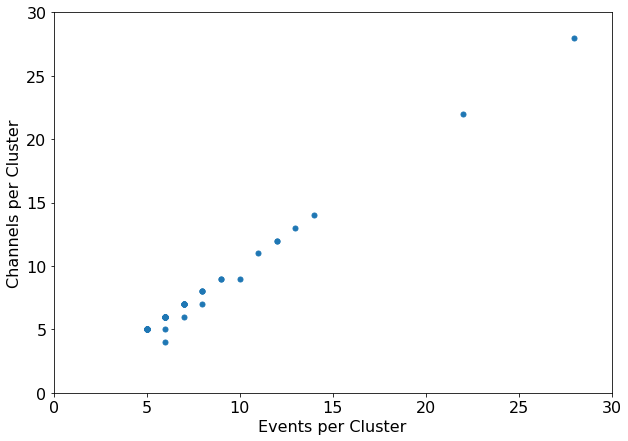

In [112]:
#Scatter plot:
plt.figure(figsize=(10,7)) # lets you make a custom size for your plot
plt.tick_params(labelsize=16) #adjust fontsize of axis ticks
#plt.title('First 3 Towers of ds3564',fontsize=16)
plt.xlabel('Events per Cluster',fontsize=16)
plt.ylabel('Channels per Cluster',fontsize=16)

plt.scatter(eventspercluster,channelspercluster, marker='.',s=100)
#plt.gca().set_yscale("log") #set y-scale to be logarithmic (x-scale works the same way)
plt.ylim([0,30])
plt.xlim([0,30])

(382.0, 383.0)

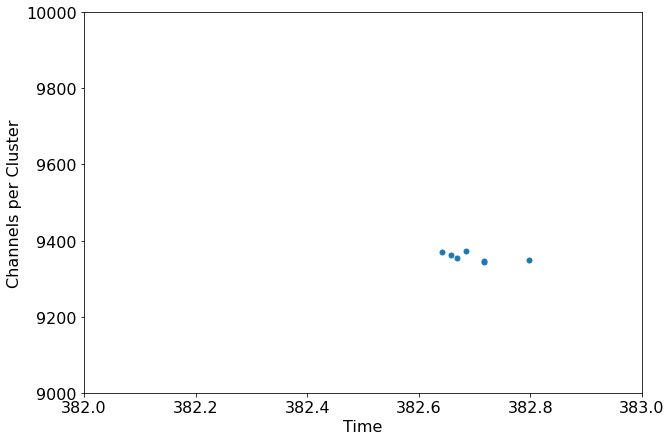

In [132]:
clusterdata = timeclusterdata.loc[timeclusters[0]]

#Scatter plot:
plt.figure(figsize=(10,7)) # lets you make a custom size for your plot
plt.tick_params(labelsize=16) #adjust fontsize of axis ticks
#plt.title('First 3 Towers of ds3564',fontsize=16)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Channels per Cluster',fontsize=16)

plt.scatter(clusterdata['Time'] + clusterdata['MaxPosInWindow']/1000.0,clusterdata['Baseline'] + clusterdata['MaxToBaseline'], marker='.',s=100)
#plt.gca().set_yscale("log") #set y-scale to be logarithmic (x-scale works the same way)
plt.ylim([9000,10000])
plt.xlim([382,383])

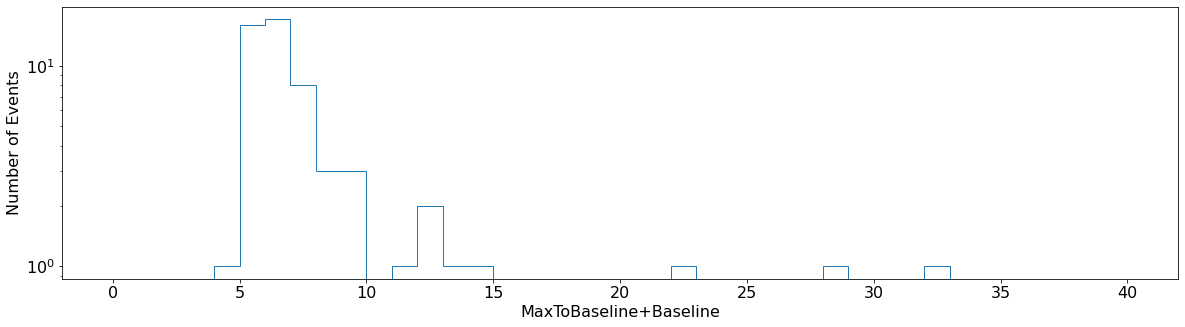

In [139]:
plt.figure(figsize=(20,5)) # lets you make a custom size for your plot
plt.tick_params(labelsize=16) #adjust fontsize of axis ticks
plt.ylabel('Number of Events',fontsize=16)
plt.xlabel('MaxToBaseline+Baseline',fontsize=16)
array=plt.hist(channelspercluster, np.linspace(0,40,41), histtype='step')
plt.gca().set_yscale("log")

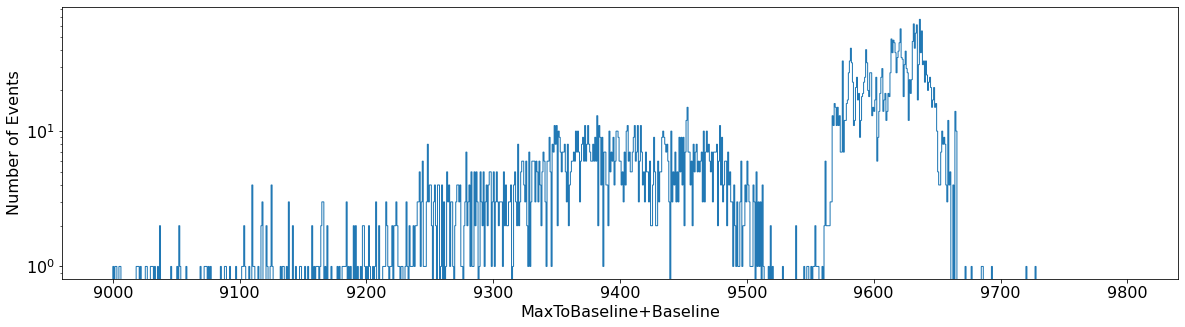

In [41]:
plt.figure(figsize=(20,5)) # lets you make a custom size for your plot
plt.tick_params(labelsize=16) #adjust fontsize of axis ticks
plt.ylabel('Number of Events',fontsize=16)
plt.xlabel('MaxToBaseline+Baseline',fontsize=16)
array=plt.hist(not_noisydata['MaxToBaseline'].values+not_noisydata['Baseline'].values, np.linspace(9000,9800,1001), histtype='step')
plt.gca().set_yscale("log")

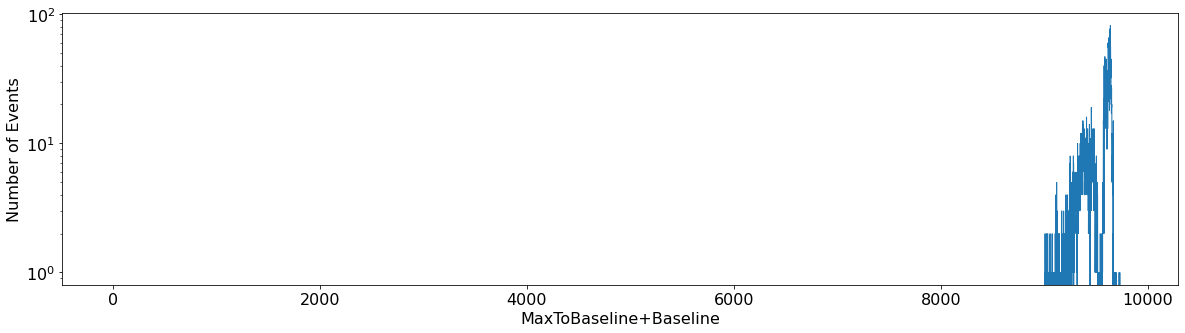

In [42]:
plt.figure(figsize=(20,5)) # lets you make a custom size for your plot
plt.tick_params(labelsize=16) #adjust fontsize of axis ticks
plt.ylabel('Number of Events',fontsize=16)
plt.xlabel('MaxToBaseline+Baseline',fontsize=16)
array=plt.hist(louddata['MaxToBaseline'].values+louddata['Baseline'].values, np.linspace(0,9800,9801), histtype='step')
plt.gca().set_yscale("log")

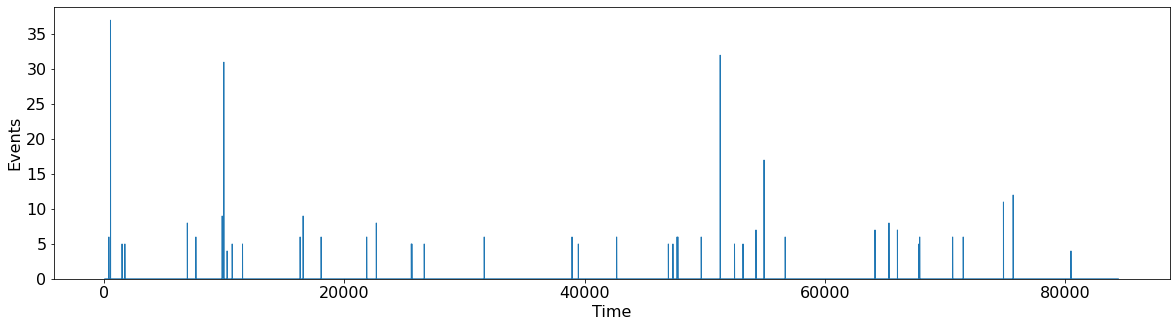

In [135]:
plt.figure(figsize=(20,5)) # lets you make a custom size for your plot
plt.tick_params(labelsize=16) #adjust fontsize of axis ticks
plt.ylabel('Events',fontsize=16)
plt.xlabel('Time',fontsize=16)
array=plt.hist(timeclusterdata['Time'].values, np.linspace(0,84500,84501), histtype='step')
#plt.gca().set_yscale("log")